### <font color="#003865"> ANOP 370<br> Prescriptive Analytics <br><br>

# <center> <font color="#E87722"> MLB Umpire Scheduling Probelm<br>

### <center> Kevin Collier and Ben Ferguson <br><br> Bucknell University <br> Fall 2023

# MLB USP Formulation

## Decision Variables:
- $Y_{k, c, d, w}$: binary variables for if crew k is in city c at week w and moves to city d in the following week.
- $X_{k, c, w}$: binary variables for if crew k is in city c during week w.

## Objective:
Minimize the total distance traveled by all crews over all weeks:


Min: $\sum_{k=1}^{\text{num_crews}} \sum_{c=1}^{\text{num_cities}} \sum_{d=1}^{\text{num_cities}} \sum_{w=1}^{\text{num_weeks}} Y_{k, c, d, w} \times \text{distance_matrix}[c][d]$

## Constraints:
1. Assignment of crews to cities and movement between cities:
   - $Y_{k, c, d, w} \leq X_{k, c, w}$
   - $Y_{k, c, d, w} \leq X_{k, d, w + 1}$
   - $X_{k, c, w} + X_{k, d, w + 1} + (1 - Y_{k, c, d, w}) \leq 2$
   
   

2. Each city in the schedule is assigned one crew each week:
   - $\sum_{k=1}^{\text{num_crews}} X_{k, c, w} = 1$  for each week w and city c in schedule



3. Each crew travels to a new city in the schedule per week:
   - $\sum_{\text{c in schedule}}^{\text{num_crews}} X_{k, c, w} = 1$ for each crew k and week w
   

4. A crew can't be in the same city two weeks in a row:
   - $X_{k, c, w} + X_{k, c, w + 1} \leq 1$ for each crew k, city c, and week w

## Schedule for 6 teams over 6 weeks. Each team plays each other twice, once home and once away.

| Week | Game | Home | Away |
|------|------|------|------|
| 1    | 1    | Bos  | LA   |
|      | 2    | Hou  | Det  |
|      | 3    | Atl  | Tam  |
| 2    | 4    | LA   | Bos  |
|      | 5    | Det  | Hou  |
|      | 6    | Atl  | Tam  |
| 3    | 7    | Bos  | Hou  |
|      | 8    | LA   | Atl  |
|      | 9    | Tam  | Det  |
| 4    | 10   | LA   | Bos  |
|      | 11   | Det  | Hou  |
|      | 12   | Tam  | Atl  |
| 5    | 13   | Bos  | LA   |
|      | 14   | Hou  | Det  |
|      | 15   | Tam  | Atl  |
| 6    | 16   | Hou  | Bos  |
|      | 17   | Atl  | LA   |
|      | 18   | Det  | Tam  |

In [1]:
# Variables
teams = ['Bos',	'LA', 'Hou', 'Det', 'Atl', 'Tam']

# Distance matrix showing the distance between each city. It follows the order represented in the teams list.
distance_matrix = [
    [0, 2991.30, 1847.90, 707, 1080.60, 1343.60],
    [2991.30, 0, 1547.80, 2281.80, 2175.00, 2526.60],
    [1847.90, 1547.80, 0, 1300.30, 792.8, 980.4],
    [707, 2281.80, 1300.30, 0, 722.4, 1178.00],
    [1080.60, 2175.00, 792.8, 722.4, 0, 455.9],
    [1343.60, 2526.60, 980.4, 1178.00, 455.9, 0]
]

num_weeks = 6
num_crews = 3
num_cities = 6

# Coordinates of each home city
positions = {'Bos': (42.3601, 71.0589),
 'LA': (34.0549, 118.2426),
 'Hou': (29.7604, 95.3698),
 'Det': (42.3314, 83.0458),
 'Atl': (33.7488, 84.3877), 
'Tam': (27.9517, 82.4588)}

# Schedules for the 6 weeks
home_city_schedule = [
    ['Bos','Atl', 'Det'], 
    ['Hou','LA','Tam'],
    ['Bos','Hou', 'Det'],
    ['LA','Det','Tam'],
    ['Bos','Hou','Tam'],
    ['Hou','Atl','Det']
]
away_city_schedule = [
    ['LA', 'Det', 'Tam'],
    ['Bos', 'Hou', 'Atl'],
    ['Hou', 'Atl', 'Det'],
    ['Bos', 'Hou', 'Atl'],
    ['LA', 'Det', 'Atl'],
    ['Bos', 'LA', 'Tam']
]

In [2]:
import gurobipy as gb
from gurobipy import GRB

model = gb.Model()

# if crew k is in city c on week w, but then moves on to city d in the following week
Y = {}
for k in range(num_crews):
    for c in range(num_cities):
        for d in range(num_cities):
            for w in range(num_weeks):
                Y[k, c, d, w] = model.addVar(vtype=GRB.BINARY, name=f"Y_{k}_{c}_{d}_{w}")
                
# If crew k, is in city c, during week w
# This will help define the constraints
X = {}
for k in range(num_crews):
    for c in range(num_cities):
        for w in range(num_weeks):
            X[k, c, w] = model.addVar(vtype=GRB.BINARY, name=f"X_{k}_{c}_{w}")            

for k in range(num_crews):
    for c in range(num_cities):
        for d in range(num_cities):
            for w in range(num_weeks - 1):
                model.addConstr(Y[k, c, d, w] <= X[k, c, w])
                model.addConstr(Y[k, c, d, w] <= X[k, d, w + 1])
                model.addConstr(X[k, c, w] + X[k, d, w + 1] + (1 - Y[k, c, d, w]) <= 2) 

# Each city in the schedule has one crew each week
for w in range(num_weeks):
    for city in home_city_schedule[w]:
        model.addConstr(gb.quicksum(X[k, teams.index(city), w] for k in range(num_crews)) == 1)

# Each crew travels to a new city in the schedule per week
for k in range(num_crews):
    for w in range(num_weeks):
        model.addConstr(gb.quicksum(X[k, teams.index(city), w] for city in home_city_schedule[w]) == 1)
        
        
# A crew can't be in the same city two weeks in a row / a crew has to change cities each week                
for k in range(num_crews):
    for c in range(num_cities):
        for w in range(num_weeks - 1):
            model.addConstr(X[k, c, w] + X[k, c, w + 1] <= 1)
        
# Objective function
# Y[k,c,d,w]*distance[c,d]
obj = gb.quicksum(
    Y[k, c, d, w] * distance_matrix[c][d]
    for k in range(num_crews)
    for c in range(num_cities)
    for d in range(num_cities)
    for w in range(num_weeks)
)
model.setObjective(obj, GRB.MINIMIZE)

model.optimize()

# This prints the output of where each crew is each week.
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found!")
    for w in range(num_weeks):
        print(f"Week {w + 1} Schedule:")
        for k in range(num_crews):
            city_assigned = [teams[c] for c in range(num_cities) if X[k, c, w].x > 0]
            if city_assigned:
                print(f"Crew {k + 1}: {', '.join(city_assigned)}")
            else:
                print(f"Crew {k + 1}: No assignment")
else:
    print("No optimal solution found.")

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1746 rows, 756 columns and 4068 nonzeros
Model fingerprint: 0xd8c2db1e
Variable types: 0 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 22733.000000
Presolve removed 1170 rows and 198 columns
Presolve time: 0.02s
Presolved: 576 rows, 558 columns, 1638 nonzeros
Variable types: 0 continuous, 558 integer (558 binary)

Root relaxation: objective 0.000000e+00, 43 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

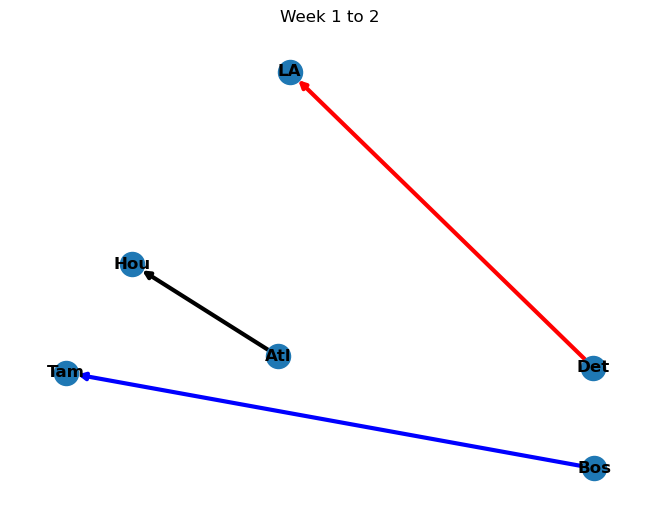

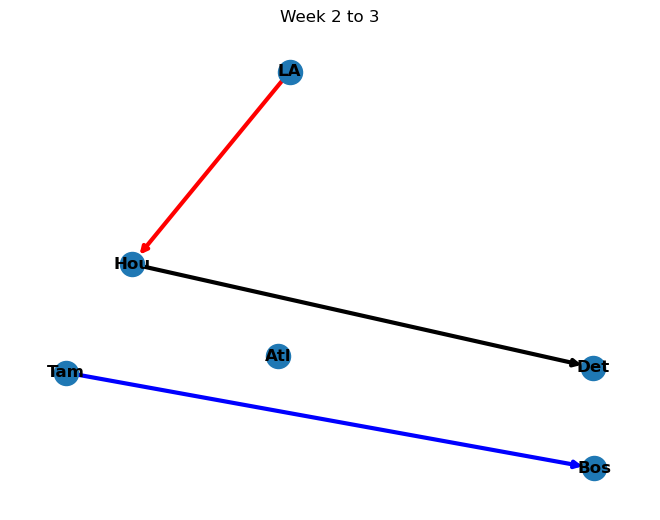

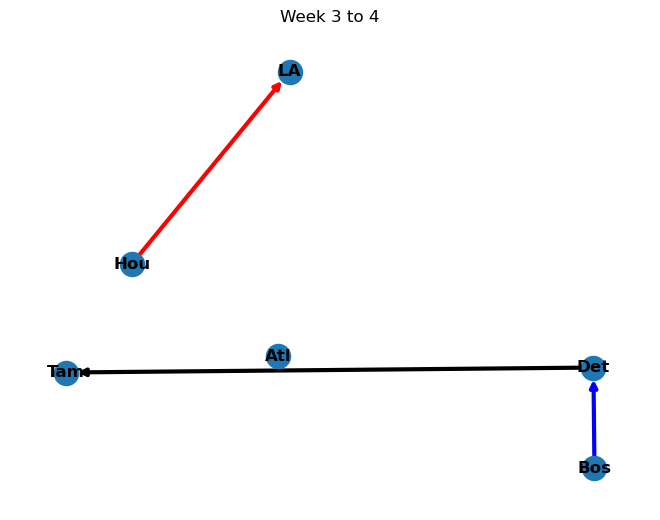

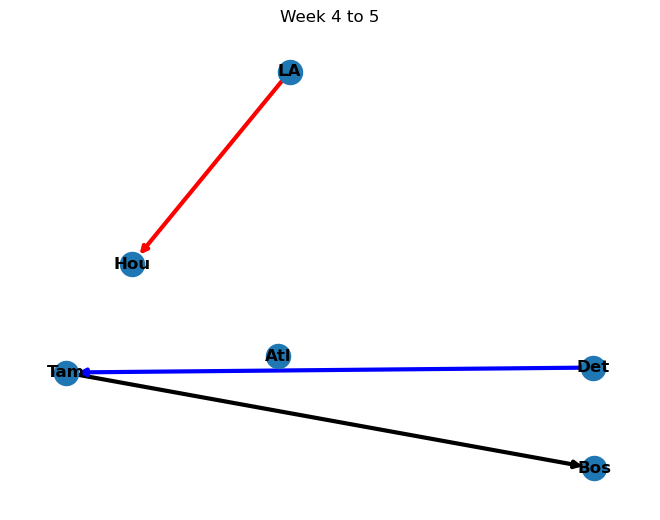

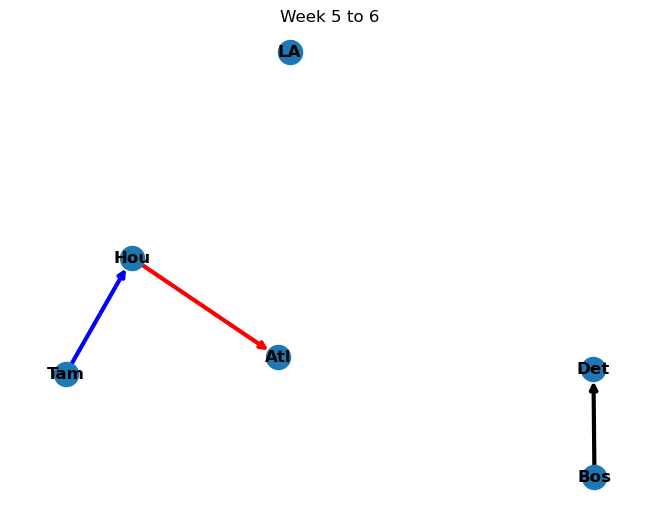

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to build the graph
def build_graph():
    G = nx.DiGraph()
    for city in teams: 
        G.add_node(city)
    return G

# Function to draw the graph
def draw_graph(G, edges, week):
    positions = {'Bos': (42.3601, 71.0589),
                 'LA': (34.0549, 118.2426),
                 'Hou': (29.7604, 95.3698),
                 'Det': (42.3314, 83.0458),
                 'Atl': (33.7488, 84.3877),
                 'Tam': (27.9517, 82.4588)}

   # Define colors for crews
    colors = {1: 'blue', 2: 'red', 3: 'green'} 
    
    edge_colors = [colors.get(edge[2], 'black') for edge in edges]
    
    nx.draw(
        G, pos=positions, edgelist=[(edge[0], edge[1]) for edge in edges],
        edge_color=edge_colors, with_labels=True, font_weight='bold', width=3.0, arrows=True, 
    )
    
    plt.title(f"Week {week+1} to {week+2}")
    plt.show()


# Show the movement for each week (week 1 to week 2, week 2 to week 3, etc.)
for week in range(num_weeks-1):
    G = build_graph()
    edges = []
 
    for k in range(num_crews):
        for c in range(num_cities):
            for d in range(num_cities):
                if Y[k, c, d, week].x > 0: 
                    edges.append((teams[c], teams[d], k))

    # Draw graph for all crew movement per week
    draw_graph(G, edges, week)